In [1]:
import cv2
from matplotlib import pyplot as plt

import numpy as np
import glob
import os
import keras
from keras.layers import Convolution2D,MaxPooling2D,BatchNormalization,Flatten,Dense,Dropout
from keras.models import Sequential
os.environ['KERAS_BACKEND']='tensorflow'

path='/content/drive/MyDrive/Training3/*'
train_images = []
train_labels = [] 
count=0
SIZE=128
for directory_path in glob.glob(path):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        print(count)
        count+=1
        img = cv2.imread(img_path)
        img=cv2.resize(img,(SIZE,SIZE))
        train_images.append(img)
        train_labels.append(label) 

train_images=np.array(train_images)
train_labels=np.array(train_labels)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

Streaming output truncated to the last 5000 lines.
765
/content/drive/MyDrive/Training3/glioma_tumor/gg (476).jpg
766
/content/drive/MyDrive/Training3/glioma_tumor/gg (141).jpg
767
/content/drive/MyDrive/Training3/glioma_tumor/gg (379).jpg
768
/content/drive/MyDrive/Training3/glioma_tumor/gg (471).jpg
769
/content/drive/MyDrive/Training3/glioma_tumor/gg (115).jpg
770
/content/drive/MyDrive/Training3/glioma_tumor/gg (390).jpg
771
/content/drive/MyDrive/Training3/glioma_tumor/gg (491).jpg
772
/content/drive/MyDrive/Training3/glioma_tumor/gg (254).jpg
773
/content/drive/MyDrive/Training3/glioma_tumor/gg (405).jpg
774
/content/drive/MyDrive/Training3/glioma_tumor/gg (13).jpg
775
/content/drive/MyDrive/Training3/glioma_tumor/gg (110).jpg
776
/content/drive/MyDrive/Training3/glioma_tumor/gg (341).jpg
777
/content/drive/MyDrive/Training3/glioma_tumor/gg (362).jpg
778
/content/drive/MyDrive/Training3/glioma_tumor/gg (411).jpg
779
/content/drive/MyDrive/Training3/glioma_tumor/gg (35).jpg
780
/c

In [2]:
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(64, 3, activation = activation, input_shape = (SIZE, SIZE, 3),data_format='channels_last'))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(32, 3, activation = activation, input_shape = (SIZE, SIZE, 3),data_format='channels_last'))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(32, 3, activation = activation, input_shape = (SIZE, SIZE, 3),data_format='channels_last'))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(64, 5, activation = activation))
feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
feature_extractor.add(BatchNormalization(axis=-1))
feature_extractor.add(Dropout(0.2))

# feature_extractor.add(Conv2D(64, 5, activation = activation, padding = 'same'))
# feature_extractor.add(MaxPooling2D(pool_size = (2, 2), data_format="channels_last"))
# feature_extractor.add(BatchNormalization(axis=-1))
# feature_extractor.add(Dropout(0.2))


feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(512, activation = activation)(x)
x=BatchNormalization(axis=-1)(x)
x=Dropout(0.2)(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

##########################################
#Train the CNN model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

X_train,X_test,y_train,y_test=train_test_split(train_images,train_labels_encoded,test_size=0.2,random_state=0)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

import random

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

# Prepare data-augmenting data generator
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        preprocessing_function=add_noise,
    )
      
train_datagen.fit(X_train)

train_generator = train_datagen.flow(
    X_train,
    y_train_one_hot,
    batch_size = 32)
history =cnn_model.fit_generator(
        train_generator,
        steps_per_epoch = 70,
        epochs = 300,
        validation_data = (X_test,y_test_one_hot)
)
# history=cnn_model.fit(X_train,y_train_one_hot,batch_size=32,verbose=1,epochs=100,validation_split=0.1,shuffle=False)
print("Test_Accuracy: {:.2f}%".format(cnn_model.evaluate(X_test,y_test_one_hot)[1]*100))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
70/70 [==============================] - 21s 190ms/step - loss: 1.8036 - accuracy: 0.4003 - val_loss: 4.0899 - val_accuracy: 0.1868
Epoch 2/300
70/70 [==============================] - 13s 183ms/step - loss: 1.3743 - accuracy: 0.4180 - val_loss: 1.7926 - val_accuracy: 0.3262
Epoch 3/300
70/70 [==============================] - 13s 184ms/step - loss: 1.3131 - accuracy: 0.4574 - val_loss: 1.1943 - val_accuracy: 0.5237
Epoch 4/300
70/70 [==============================] - 13s 183ms/step - loss: 1.2228 - accuracy: 0.4972 - val_loss: 1.2573 - val_accuracy: 0.5360
Epoch 5/300
70/70 [==============================] - 13s 182ms/step - loss: 1.2060 - accuracy: 0.4760 - val_loss: 1.0910 - val_accuracy: 0.6064
Epoch 6/300
70/70 [==============================] - 13s 183ms/step - loss: 1.1778 - accuracy: 0.4989 - val_loss: 1.1020 - val_accuracy: 0.5590
Epoch 7/300
70/70 [==============================] - 13s 183ms/step - loss: 1.1109 - accuracy: 0.5452 - val_loss: 1.0075 - val_accuracy:

In [3]:
# Machine learning portion
X_for_RF = feature_extractor.predict(X_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 60, random_state = 42)
RF_model.fit(X_for_RF, y_train)

from sklearn import svm
SVM_model = svm.SVC(kernel='rbf',decision_function_shape='ovo',C=10,probability=True)  #For multiclass classification
SVM_model.fit(X_for_RF, y_train)


#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(X_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
prediction_SVM=SVM_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
# prediction_RF = le.inverse_transform(prediction_RF)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM))

Accuracy =  0.9173047473200613
Accuracy =  0.9525267993874426


In [4]:
import pickle
filename="model_97.pkl"
with open(filename,'wb') as file:
    pickle.dump(SVM_model,file)

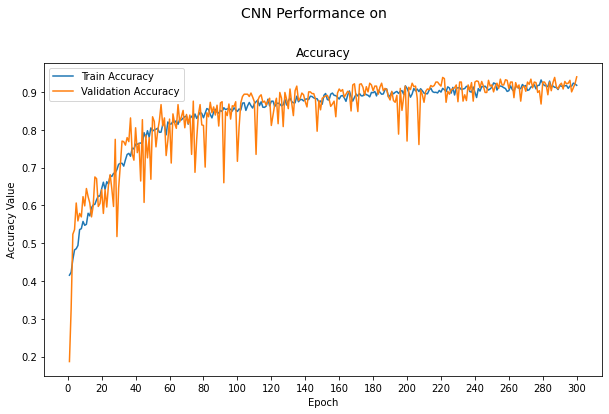

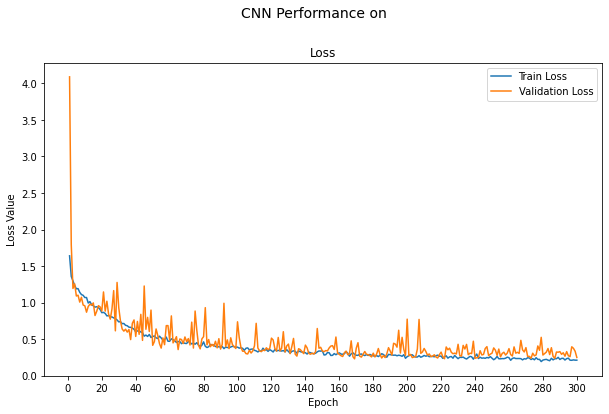

In [5]:
# loss and accuracy variance
f,ax1 = plt.subplots(1,figsize=(10, 6))
t = f.suptitle('CNN Performance on', fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, max_epoch, 20))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax1.figure.savefig('accuracy_variance97.png')

f1,ax2 = plt.subplots(1,figsize=(10, 6))
t = f1.suptitle('CNN Performance on', fontsize=14)
f1.subplots_adjust(top=0.85, wspace=0.3)
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, max_epoch, 20))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax2.figure.savefig('loss_variance97.png')

              precision    recall  f1-score   support

      glioma       0.95      0.92      0.93       191
  meningioma       0.96      0.95      0.95       187
    no tumor       0.89      0.94      0.92        90
   pituitary       0.98      1.00      0.99       185

    accuracy                           0.95       653
   macro avg       0.95      0.95      0.95       653
weighted avg       0.95      0.95      0.95       653



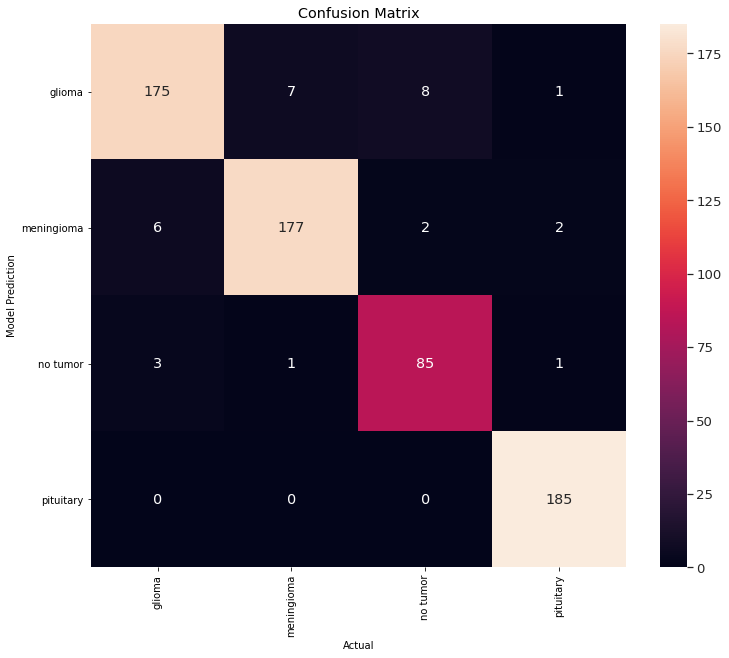

In [6]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,SVM_model.predict(X_test_feature))


fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.set(font_scale=1.2)
axes=sns.heatmap(cm, annot=True, ax=ax,fmt='.3g')
class_labels = ['glioma','meningioma','no tumor','pituitary']

axes.set_xlabel('Actual')
axes.set_ylabel('Model Prediction')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')
axes.figure.savefig("confusion_matrix_97.png")

# classification report
from sklearn.metrics import classification_report
report=classification_report(y_test,SVM_model.predict(X_test_feature),target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      glioma       0.95      0.85      0.90       191
  meningioma       0.85      0.93      0.88       187
    no tumor       0.91      0.90      0.91        90
   pituitary       0.96      0.99      0.98       185

    accuracy                           0.92       653
   macro avg       0.92      0.92      0.92       653
weighted avg       0.92      0.92      0.92       653



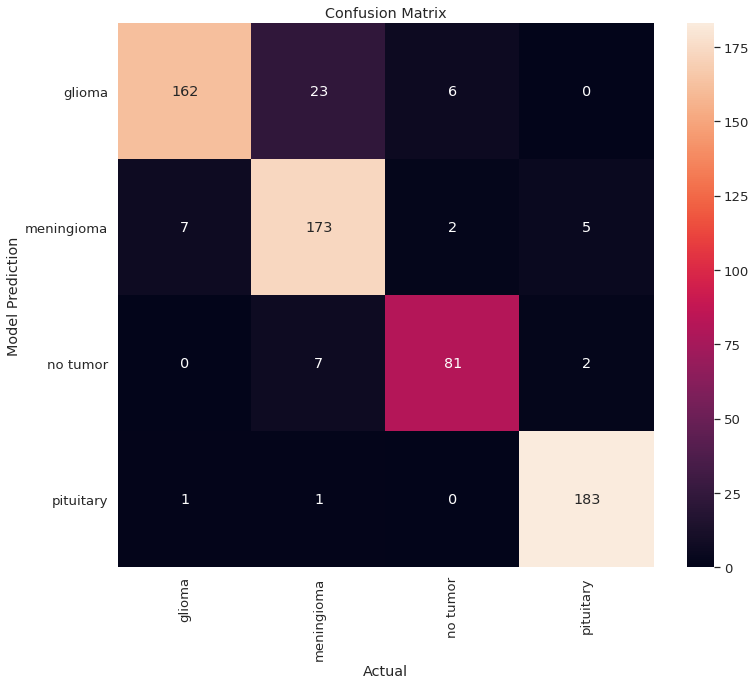

In [7]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,RF_model.predict(X_test_feature))


fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.set(font_scale=1.2)
axes=sns.heatmap(cm, annot=True, ax=ax,fmt='.3g')
class_labels = ['glioma','meningioma','no tumor','pituitary']

axes.set_xlabel('Actual')
axes.set_ylabel('Model Prediction')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')
axes.figure.savefig("confusion_matrix97RF.png")

# classification report
from sklearn.metrics import classification_report
report=classification_report(y_test,RF_model.predict(X_test_feature),target_names=class_labels)
print(report)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

      glioma       0.97      0.90      0.93       191
  meningioma       0.94      0.93      0.93       187
    no tumor       0.90      0.94      0.92        90
   pituitary       0.94      0.99      0.97       185

    accuracy                           0.94       653
   macro avg       0.94      0.94      0.94       653
weighted avg       0.94      0.94      0.94       653



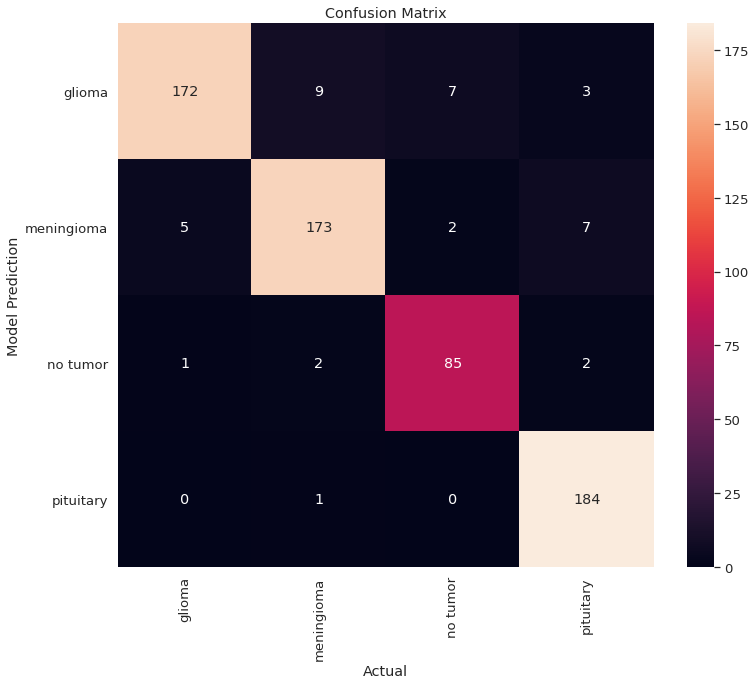

In [8]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred=cnn_model.predict_generator(X_test)
y_pred = np.argmax(y_pred, axis=1) 
cm=confusion_matrix(y_test,y_pred)


fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.set(font_scale=1.2)
axes=sns.heatmap(cm, annot=True, ax=ax,fmt='.3g')
class_labels = ['glioma','meningioma','no tumor','pituitary']

axes.set_xlabel('Actual')
axes.set_ylabel('Model Prediction')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')
axes.figure.savefig("confusion_matrix_cnn.png")

# classification report
from sklearn.metrics import classification_report
report=classification_report(y_test,y_pred,target_names=class_labels)
print(report)

0.9959579564445594 0.9861594227147045 0.9904912773876432


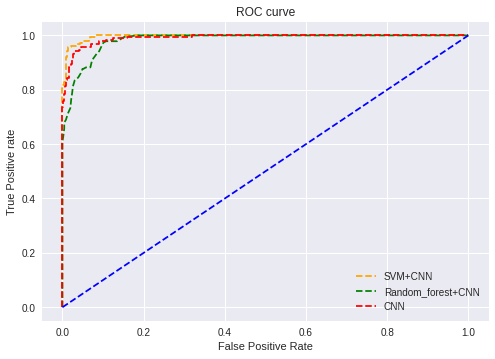

In [9]:
# ROC-AUC method comparison
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob1=SVM_model.predict_proba(X_test_feature)
pred_prob2=RF_model.predict_proba(X_test_feature)
pred_prob3=cnn_model.predict(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1,multi_class='ovo')
auc_score2 = roc_auc_score(y_test, pred_prob2,multi_class='ovo')
auc_score3 = roc_auc_score(y_test, pred_prob3,multi_class='ovo')
print(auc_score1, auc_score2,auc_score3)

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM+CNN')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Random_forest+CNN')
plt.plot(fpr3, tpr3, linestyle='--',color='red', label='CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_method_comparison',dpi=300)
plt.show();

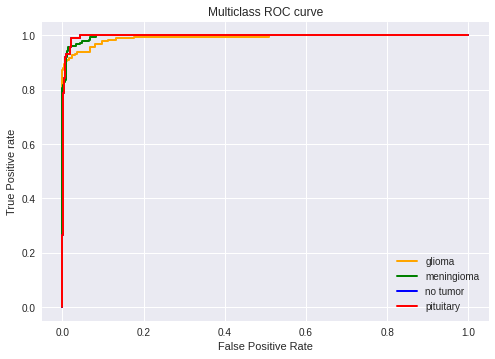

In [10]:
# ROC-AUC class comparison
fpr1 = {}
tpr1 = {}
thresh1 ={}
n_class = 4
for i in range(n_class):    
    fpr1[i], tpr1[i], thresh1[i] = roc_curve(y_test, pred_prob1[:,i], pos_label=i)    
# plotting    
plt.plot(fpr1[0], tpr1[0],linewidth=2,color='orange', label='glioma')
plt.plot(fpr1[1], tpr1[1],linewidth=2,color='green', label='meningioma')
plt.plot(fpr1[2], tpr1[2],linewidth=2,color='blue', label='no tumor')
plt.plot(fpr1[2], tpr1[2],linewidth=2,color='red', label='pituitary')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC_svm97',dpi=300)





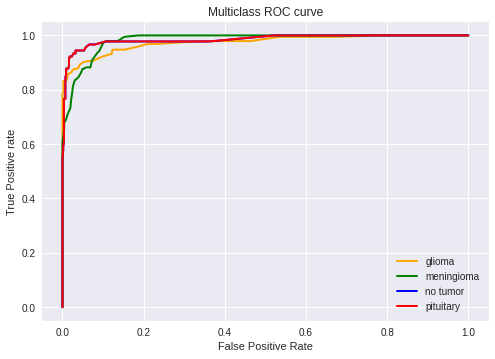

In [11]:
fpr2 = {}
tpr2 = {}
thresh2 ={}

n_class = 4

for i in range(n_class):    
    fpr2[i], tpr2[i], thresh2[i] = roc_curve(y_test, pred_prob2[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr2[0], tpr2[0],linewidth=2,color='orange', label='glioma')
plt.plot(fpr2[1], tpr2[1],linewidth=2,color='green', label='meningioma')
plt.plot(fpr2[2], tpr2[2],linewidth=2,color='blue', label='no tumor')
plt.plot(fpr2[2], tpr2[2],linewidth=2,color='red', label='pituitary')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC_rf97',dpi=300)

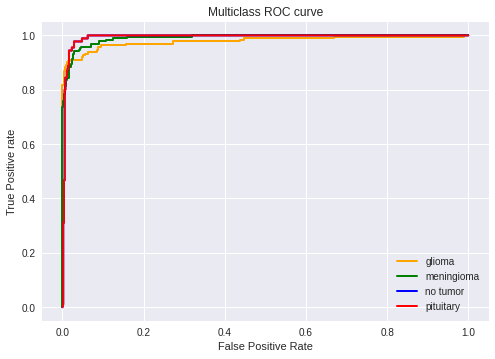

In [12]:
fpr3 = {}
tpr3 = {}
thresh3 ={}

n_class = 4

for i in range(n_class):    
    fpr3[i], tpr3[i], thresh3[i] = roc_curve(y_test, pred_prob3[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr3[0], tpr3[0],linewidth=2,color='orange', label='glioma')
plt.plot(fpr3[1], tpr3[1],linewidth=2,color='green', label='meningioma')
plt.plot(fpr3[2], tpr3[2],linewidth=2,color='blue', label='no tumor')
plt.plot(fpr3[2], tpr3[2],linewidth=2,color='red', label='pituitary')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC_cnn97',dpi=300)

In [13]:
print(X_test.shape)

(653, 128, 128, 3)


In [14]:
import cv2
import skimage
from skimage import io,img_as_float
from matplotlib import pyplot as plt
from skimage.filters import threshold_multiotsu,sobel,gabor
from skimage.feature.texture import greycomatrix,greycoprops,local_binary_pattern
from scipy.stats import kurtosis,skew
from skimage import img_as_ubyte
import numpy as np
import glob
import os
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import pickle
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater

def watershed_segment(image):
    imgray1=image
    imgray0=cv2.medianBlur(imgray1,3)
    kernel=np.ones((3,3),np.uint8)
    imgray=cv2.erode(imgray0,kernel,iterations=3)
    return imgray

X_train2=X_train[:,:,:,0]
X_test2=X_test[:,:,:,0]
X_train3=[]
for img in range(X_train2.shape[0]):  #iterate through each file 
        print(img)
        input_img = X_train2[img, :,:]
        img_arr = input_img
        img=watershed_segment(img_arr)
        X_train3.append(img)
X_train3=np.array(X_train3)
X_test3=[]
for img in range(X_test2.shape[0]):  #iterate through each file 
        print(img)
        input_img = X_train2[img, :,:]
        img_arr = input_img
        img=watershed_segment(img_arr)
        X_test3.append(img)
X_test3=np.array(X_test3)



def feature_extractor(dataset):
    x_train = dataset
    image_dataset = []
    featLength = 50
    trainFeats = np.zeros((len(x_train),featLength))
    
    for image in range(x_train.shape[0]):  #iterate through each file 
        print(image)
        input_img = x_train[image, :,:]
        img_arr = input_img
        # GLCM
        glcm_mat=greycomatrix(img_arr,[2,3,4],[0,np.pi/2,np.pi/4],256,symmetric=True,normed=True)
        contrast=greycoprops(glcm_mat,prop="contrast")
        contrast=contrast.reshape(-1)
        dissimilarity=greycoprops(glcm_mat,prop="dissimilarity")
        dissimilarity=dissimilarity.reshape(-1)
        homogeneity=greycoprops(glcm_mat,prop="homogeneity")
        homogeneity=homogeneity.reshape(-1)
        energy=greycoprops(glcm_mat,prop="energy")
        energy=energy.reshape(-1)
        correlation=greycoprops(glcm_mat,prop="correlation")
        correlation=correlation.reshape(-1)
        feat_glcm=np.concatenate([contrast,dissimilarity,homogeneity,energy,correlation],axis=0)
       
        gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
        gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
        gabor_hist,_ = np.histogram(gaborFilt,8)
        gabor_hist = np.array(gabor_hist,dtype=float)
        gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
        gabor_energy = np.nansum(gabor_prob**2)
        gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
        
        #gray level features
        mean=np.mean(img_arr)
        standard_dev=np.std(img_arr)
        variance=np.var(img_arr)
        kurtosis_v=kurtosis(img_arr,axis=None)
        skewness=skew(img_arr,axis=None)
        
        feat_gray=np.array([mean,standard_dev,variance])
        # Concatenating features(2+5+2)    
        concat_feat = np.concatenate((feat_glcm,[gabor_energy,gabor_entropy],feat_gray),axis=0)
        trainFeats[image,:] = concat_feat #Stacking features vectors for each image
  
        # image_dataset = image_dataset.append(trainFeats)
    print("done")    
    return trainFeats
####################################################################
image_features = feature_extractor(X_train3)
# image_features.to_csv("gaborexample.csv")
image_features = np.expand_dims(image_features, axis=0)
X_for_RF2 = np.reshape(image_features, (X_train3.shape[0], -1)) 

test_features = feature_extractor(X_test3)
test_features = np.expand_dims(test_features, axis=0)
Test_for_RF2 = np.reshape(test_features, (X_test3.shape[0], -1))  #Reshape to #images, features

# pca=PCA(n_components=40)
# X_for_RF=pca.fit_transform(X_for_RF)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in multiply


44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307


In [15]:
print(Test_for_RF2.shape)

(653, 50)


In [ ]:
XX_train,XX_test=X_for_RF2,Test_for_RF2
XX_train=XX_train/255.0
XX_test=XX_test/255.0

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

model_params={
    'svm':{
        'model':svm.SVC(gamma='auto'),
        'params':{
            'svc__C':[1,5,7,10,15,20,50,60,100],
            'svc__kernel':['rbf','poly','sigmoid','linear',],
            'svc__degree':[3,8],
            'svc__coef0':[0.001,0.5,10],
            'svc__gamma':['auto','scale'],
            'svc__decision_function_shape':['ovo','ovr']
        }
    },
    'random_forest':{
        'model':RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators':[30,40,50,60]
        }
    },
    'logistic_regression':{
        'model':LogisticRegression(),
        'params':{
            'logisticregression__C':[1,5]
        }
    }
}

scores=[]
best_estimators={}

for algo,mp in model_params.items():
    pipe=make_pipeline(StandardScaler(),mp['model'])
    clf=GridSearchCV(pipe,mp['params'],cv=5,return_train_score=False)
    clf.fit(XX_train,y_train)
    scores.append({
        'model':algo,
        'best_score':clf.best_score_,
        'best_parameter':clf.best_params_
    })
    best_estimators[algo]=clf.best_estimator_

df=pd.DataFrame(scores,columns=["model","best_score","best_parameter"])
svm_model=best_estimators['svm']
svm_model.score(XX_test,y_test)

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_test,svm_model.predict(XX_test))


fig, ax = plt.subplots(figsize=(12,10))         # Sample figsize in inches
sns.set(font_scale=1.2)
axes=sns.heatmap(cm, annot=True, ax=ax,fmt='.3g')
class_labels = ['glioma','meningioma','no tumor','pituitary']

axes.set_xlabel('Actual')
axes.set_ylabel('Model Prediction')

tick_marks = np.arange(len(class_labels)) + 0.5

axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=0)

axes.set_title('Confusion Matrix')
axes.figure.savefig("confusion_matrix_l.png")

# classification report
from sklearn.metrics import classification_report
report=classification_report(y_test,svm_model.predict(XX_test),target_names=class_labels)
print(report)